In [ ]:
# Packages

import numpy as np
from matplotlib.pyplot import subplots , cm
import sklearn.model_selection as skm
!pip install ISLP
from ISLP import load_data , confusion_table
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_estimator # shorthand

import pandas as pd
import seaborn as sns

# Exercise 1

Use the les_93 data, this is data on members of the US Congress in the 93rd Congress in 70s. Main outcome variable is legislative effectiveness or how much of Congress's lawmaking productivity is attributable to that member for that term. Members that get a lot of bills passed with their name on them will have a higher legislative effectiveness.

You are going to predict whether a member of Congress is above or below the median of legislative effectiveness using two variables: how liberal or conservative the member is (dwnom1, where lower scores are more liberal and higher score more conservative) and how long the member has been in Congress (seniority). **Use a support vector classifier, a SVM with polynomial kernel, and a SVM with a radial kernel**.

Warning: this is not going to perform well, because turns out that predicting legislative effectiveness with just two variables is not easy! Complex phenomena often have interesting patterns that aren’t going to look as pretty as simulated data, and if things were easy to predict with two variables, you wouldn’t have much need for all these fancy algortihms.

Do your best. For each method, m**ake a confusion matrix and report how the classifier did**.

In [ ]:
from google.colab import files
uploaded = files.upload()


### 93rd congress
dat=pd.read_csv("les_93.csv")
dat = dat.dropna()
dat.convert_dtypes()
dat['effective01'] = (dat['les'] > dat['les'].median()).astype(int) #median for response
dat_X = np.array(dat[['dwnom1','seniority']]) #how liberal or conservative
dat_y = np.array(dat[['effective01']]).flatten() #response variable

Saving les_93.csv to les_93 (2).csv


In [ ]:
# Fit the Classifier for SVM classifier

svm_linear = SVC(C=10, kernel = 'linear')
svm_linear.fit(dat_X, dat_y)

SVC(C=10, kernel='linear')

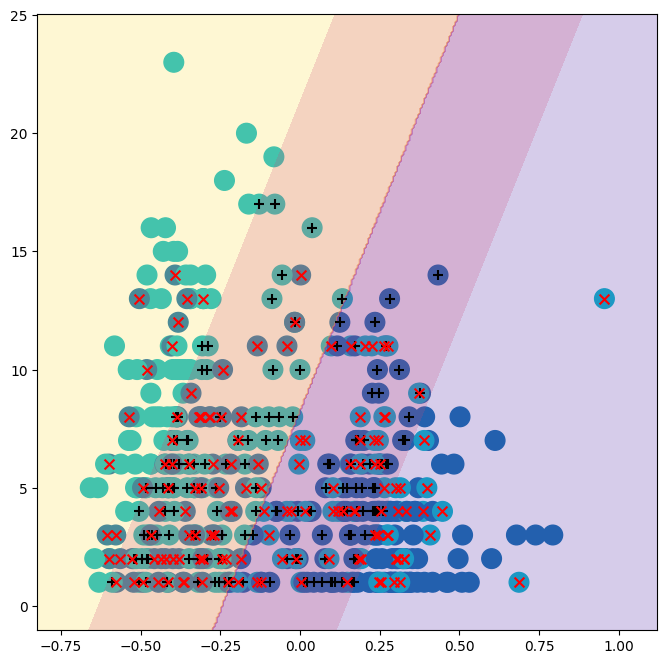

In [ ]:
# Plot for SVM classifier

fig , ax = subplots(figsize=(8,8))
plot_svm(dat_X,
dat_y,
svm_linear ,
ax=ax)

Below is my understanding taken from ISLP.

The decision boundary for the two classes is linear due to the argument kernel='linear'. Support vectors are marked with + and the remaining observations are plotted as circles. (Ch.9 ISLP lab code)

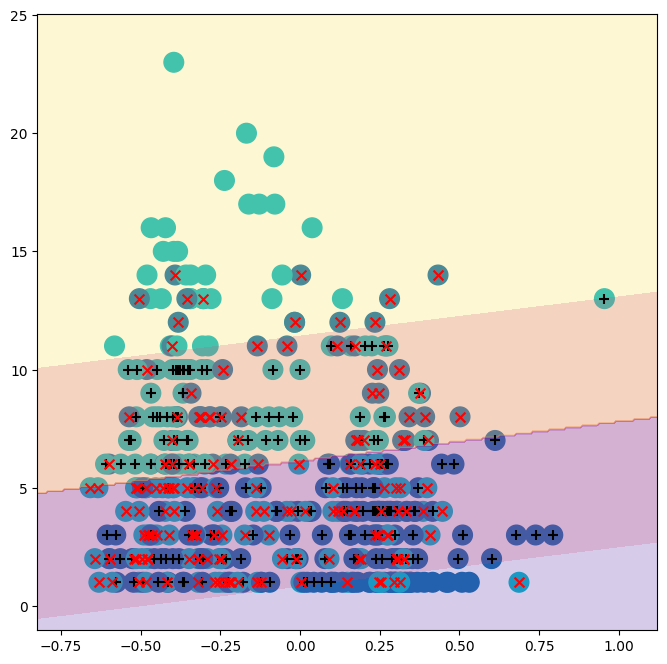

In [ ]:
# Try a smaller cost parameter, should obtain a larger number of support vectors, due to wider margin
# This is just to see what changes

svm_linear_small = SVC(C=0.01, kernel='linear')
svm_linear_small.fit(dat_X, dat_y)
fig , ax = subplots(figsize=(8,8))
plot_svm(dat_X,
dat_y,
svm_linear_small ,
ax=ax)

I used a C value of .01 there are many more support vectors as indicated by the + sign compared to the standard C value in the previous plot. However, the margin is wider due to the smaller cost parameter.

In [ ]:
# Use sklearn to tune support vector machine to find ideal C parameter

kfold = skm.KFold(5,
random_state=0,
shuffle=True)
grid = skm.GridSearchCV(svm_linear ,
{'C':[0.001,0.01,0.1,1,5,10,100]},
refit=True ,
cv=kfold ,
scoring='accuracy')
grid.fit(dat_X, dat_y)
grid.best_params_

{'C': 10}

In [ ]:
# Show accuracy results only

grid.cv_results_[('mean_test_score')]

array([0.59242134, 0.62060192, 0.67904241, 0.67433653, 0.67901505,
       0.68136799, 0.68136799])

C= 10 is the best C parameter with an accuracy score of .68. The accuracy score is also the same for the C value of 100.

In [ ]:
# Make training and test set

(X_train ,
X_test ,
y_train ,
y_test) = skm.train_test_split(dat_X,
dat_y,
test_size=0.5,
random_state=0)

In [ ]:
# Creating confusion matrix based on the C=10 best parameter

svm_ = SVC(C=10,
kernel='linear').fit(dat_X, dat_y)
y_test_hat = svm_.predict(X_test)
confusion_table(y_test_hat , y_test)

Truth,0,1
Predicted,,
0,71,28
1,34,81


When you add 71 and 81 divided by the total of 214, the accuracy score equates to about 71%. The classifier with the C=10 parameter performed slightly better than the grid.cv_results showed of 68%. The C value of 10 provides a good trade-off between bias and variance. Generally, a higher C value equates to more bias and lower variance, while a lower C value equates to lower bias but more variance. Among the three models, this model performed the best in achieving a more balanced C value and obtaining a more accurate score compared to the other two SVM models.

In [ ]:
# Fit a SVM with radial Kernel

(X_train ,
X_test ,
y_train ,
y_test) = skm.train_test_split(dat_X,
dat_y,
test_size=0.5,
random_state=0)
svm_rbf = SVC(kernel="rbf", gamma=1, C=1)
svm_rbf.fit(X_train , y_train)



SVC(C=1, gamma=1)

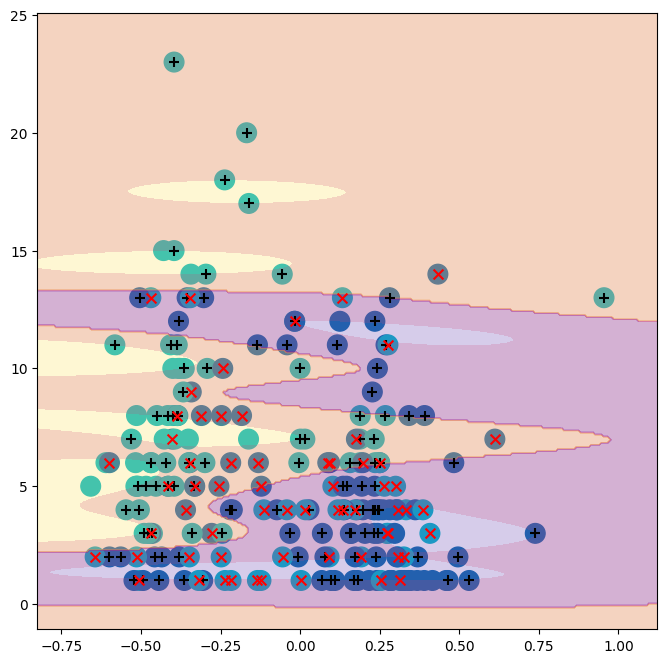

In [ ]:
# plot of SVM with radial Kernel

fig , ax = subplots(figsize=(8,8))
plot_svm(X_train ,
y_train ,
svm_rbf ,
ax=ax)

The radial kernel provides a more flexible decision boundary than the linear kernel as seen with the wavy decision boundaries. This is due to the radial kernel focusing on local behavior or nearby training observations.

In [ ]:
# cross-validation to select best C for SVM with radial kernel

kfold = skm.KFold(5,
random_state=0,
shuffle=True)
grid = skm.GridSearchCV(svm_rbf ,
{'C':[0.1,1,10,100,1000],
'gamma':[0.5,1,2,3,4]},
refit=True ,
cv=kfold ,
scoring='accuracy');
grid.fit(X_train , y_train)
grid.best_params_
best_svm = grid.best_estimator_

grid.best_params_

{'C': 100, 'gamma': 4}

Using a 5-fold cross-validation method, the best parameters are C=100 and gamma =4.

In [ ]:
# Confusion matrix for SVM radial kernel

y_hat_test = best_svm.predict(X_test)
confusion_table(y_hat_test , y_test)





Truth,0,1
Predicted,,
0,59,46
1,46,63


The accuracy score for the radial kernel with C =100 and gamma = 4 is about 57%. This is determined by adding the correct predictions together divided by the total. (63 + 59/ 214) Due to this model's lower accuracy score, it likely is not a good predictor for legislative effectiveness. The C value is also very high which suggests potential underfitting as well.

In [ ]:
# Fit a SVM with polynomial Kernel

(X_train ,
X_test ,
y_train ,
y_test) = skm.train_test_split(dat_X,
dat_y,
test_size=0.5,
random_state=0)
svm_poly = SVC(kernel="poly", gamma=1, C=1, degree =3)
svm_poly.fit(X_train , y_train)


SVC(C=1, gamma=1, kernel='poly')

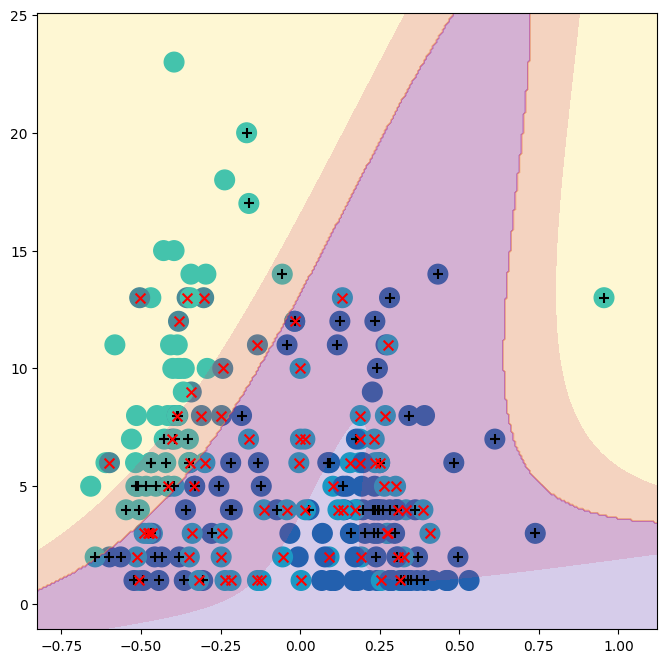

In [ ]:
# plot of SVM with poly Kernel

fig , ax = subplots(figsize=(8,8))
plot_svm(X_train ,
y_train ,
svm_poly ,
ax=ax)

The decision boundaries for the poly kernel plot are not linear but are not as noisy or messy as the radial kernel plot. The boundaries seem more defined in this plot focused on the center of the plot compared to the radial plot.

In [ ]:
# cross-validation to select best C for SVM with poly kernel

kfold = skm.KFold(5,
random_state=0,
shuffle=True)
grid = skm.GridSearchCV(svm_poly ,
{'C':[0.1,1,10],
'gamma':[0.5,1,2]},
refit=True ,
cv=kfold ,
scoring='accuracy');
grid.fit(X_train , y_train)
grid.best_params_

# I tried reducing the number of degrees, the C, and the gamma size but the grid.fit is taking way too long to find the best parameters. (15 plus minutes)
# I will leave this code here to show that I would use CV to find the best parameters, but I do not know why it won't parse.

In [ ]:
# Confusion matrix for SVM poly kernel

y_hat_test = svm_poly.predict(X_test)
confusion_table(y_hat_test , y_test)

Truth,0,1
Predicted,,
0,91,67
1,14,42


Since I couldn't find the best parameters using CV, I used the original model of gamma =1, C =1, and degree =3. The values of 133/ 214 achieved an accuracy score of 62%. This model achieved a better accuracy score than the radial kernel model, however, C was only 1 compared to 100 for the radial kernel model. The polynomial model may be overfitting the data since C is very small leading to narrower margins that are rarely violated.

# Exercise 2

In clustering, we don’t quite have the same concepts of bias and variance as we do with supervised learning methods, but a similar type of tradeoff exists. Discuss the pros and cons of high vs. low number of clusters in terms of (1) ease of learning more about each cluster and (2) within-cluster homogeneity (closeness of cases within clusters). (5 sentences max.)

In K-means clustering, using too many clusters will lead to higher within-cluster homogeneity because each cluster's observations are too similar. This can lead to overfitting since it captures the 'noise' of the dataset rather than finding significant patterns, reducing the ease of learning or interpretability. On the other hand, having too few clusters decreases within-cluster homogeneity as dissimilar points are grouped in the same clusters, this misses the nuances between the different observations and clusters leading to underfitting. The ease of learning again is reduced since the clusters are too general or not specific enough to glean any significant insights. Achieving the right balance of clusters maximizes both within-cluster homogeneity and interpretability.

# Exercise 3

Identify a scholarly paper that uses cluster analysis and is related to a politics or
policy topic that is of interest to you (please, no medical/clinical studies).
• Provide a complete citation to the paper and link to it.
• State the research question that the article addresses.
• Identify the data source(s) used in the article. Note the sample size and unit of observation.
• Describe the clustering methodology used to answer the question.
• Indicate how the results answered the research question (i.e., were the central
claims/hypotheses supported?). Why are these results important and worth reading
about?
• Provide at least one substantive critique of the paper. You may raise questions about the logic of the argument, note disjunctures between the evidence and conclusions, find problems with the data or methods used, or you might might identify an important question that was inappropriately neglected in the study. Whatever your approach, you should provide a critique that, if true, would affect the conclusions reached by the author (i.e., the author would feel forced to respond to your critique, lest the study be
undermined).

For this exercise, I found a scholarly article called Global Welfare Regimes A Cluster Analysis by Miriam Sharkh of Stanford University and Ian Gough of the London School of Economics. The article's hypothesis claims that a linear scoring approach for ranking and identifying welfare regimes does not capture the realities of country welfare or 'illfare' systems due to variations that are not linearly distributed. The article also claims that regime clusters are 'sticky' or tend to have similar characteristics over time. The researchers used a population of countries outside the OECD (Organization for Economic Cooperation and Development). OECD countries generally are wealthier with nations like the US, Canada, Denmark, and others constituting its membership. The researchers also avoided countries with less than 3 million people to avoid many 'micro-states'. Ultimately, the researchers were restricted to only 65 countries from the years 1990 and 2000, since data was needed from the same set of countries over a long period. Essentially, the researchers were measuring the effectiveness of a nation's welfare outcome through predictors such as life expectancy, public spending on education, number of immunizations, etc. Nations with higher life expectancy, more public spending, etc. were deemed as having a good welfare outcome. The data was gathered from either the local country's government or from an international organization such as the UN or the World Bank.

Both hierarchical cluster analysis and k-means cluster analysis were used. Hierarchical analysis was performed to identify homogeneous groups by the selected variables. The clusters were repeatedly combined until all observations formed one cluster. K-means cluster analysis was then used to improve the initial analysis since k-means is able to recombine observations over different iterations. The researchers determined that a k value of 10 was ideal since it showed the heterogeneity of the data and allowed for outlier countries to be clustered.

The researchers were able to ascertain that there was evidence of 'sticky' regime clusters over time. It was most pronounced for the top country cluster or cluster A which mostly consisted of European and settler countries such as Israel and Eastern Europe. The cluster analysis also confirmed the ranking of welfare regimes with the extremes of proto-welfare and insecurity regimes within the developing world. Proto-welfare are states with similar welfare outcomes to OECD states and insecurity regimes are states with very poor welfare outcomes such as Sub-Sarharn African states.

This article is important to understand because it highlights the similarities between various different states based on welfare outcomes. The clustering and ranking of nations by welfare outcomes allows for the better allocation of resources and implementation of international policy which should lead to better welfare outcomes. My main critique of this article is the data itself. It was very limited due to needing data for the same set of countries, so only 1990 and 2000 were used. The researchers would've tested 127 countries but were only able to test 65 countries. The researchers also admitted that to obtain data for the 65 countries in their dataset, they had to substitute less suitable variables since they were more widely available. I understand why the researchers made these decisions, but I think it questions the quality of the data and analysis if almost half of the eligible countries were excluded and other more suitable variables were also excluded. Perhaps the cluster analysis results would be different if the researchers had more access/ availability. The clusters themselves may have yielded different results if the other 62 countries were included. The researchers' conclusion that welfare regimes tend to be 'sticky' could've been inaccurate. If I were a business owner relying on an analysis or model that used only half of the total observations, I would question the results. However, the research question was very broad. Perhaps a more localized research question that focused on welfare outcomes for a specific geographical region would've yielded more accessible data.

Source: https://journals.sagepub.com/doi/abs/10.1177/1468018109355035

Abu Sharkh, M., & Gough, I. (2010). Global Welfare Regimes. Global Social Policy, 10(1), 27–58. https://doi.org/10.1177/1468018109355035

# References


CHAT GPT

Abu Sharkh, M., & Gough, I. (2010). Global Welfare Regimes. Global Social Policy, 10(1), 27–58. https://doi.org/10.1177/1468018109355035

Brian Perlman